#using tutorial at: https://www.kaggle.com/mumech/data-science-bowl-2017/loading-and-processing-the-sample-images

In [1]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import keras

images_path = 'images/'

Using TensorFlow backend.


In [5]:
def get_3d_data(path):
    slices = [dicom.read_file(path +'/'+s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [6]:
patients = os.listdir(images_path)
patients.sort()

sample_image = get_3d_data(images_path + patients[0])
sample_image.shape

(134, 512, 512)

In [7]:
#the images have the unavailable pixel set to -2000, changing them to 0 makes the picture clearer
sample_image[sample_image == -2000] = 0

In [9]:
import pylab

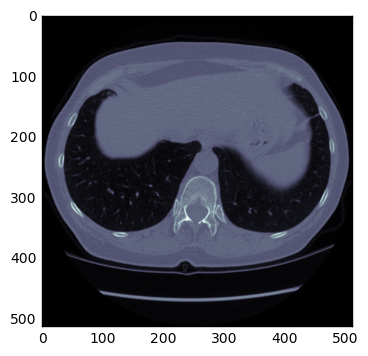

In [10]:
#same plane as the original data, cut at the Z axis
pylab.imshow(sample_image[100], cmap=pylab.cm.bone)
pylab.show()

In [11]:
#remaping the image to 1 standard deviation of the average and clipping it to 0-1
img_std = np.std(sample_image)
img_avg = np.average(sample_image)
std_image = np.clip((sample_image - img_avg + img_std) / (img_std * 2), 0, 1)

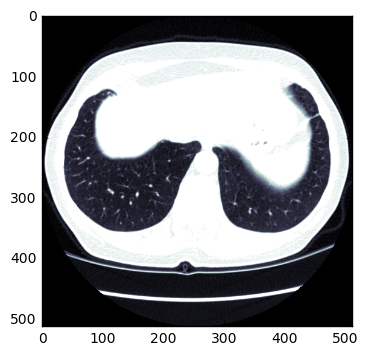

In [12]:
#same cut as before, a bit easier to spot the features
pylab.imshow(std_image[100], cmap=pylab.cm.bone)
pylab.show()

In [13]:
# load training labels
labels_csv = pd.read_csv('stage1_labels.csv', index_col='id')

# Remove the (single) unlabbeled patient from our list
patients = labels_csv.ix[patients].dropna().index

# And finally get the training labels
train_labels = labels_csv.ix[patients].cancer.astype(np.float16).as_matrix()
train_labels = train_labels.reshape([len(train_labels), 1])

In [20]:
# Loads, resizes and processes the image
def process_image(path):
    img = get_3d_data(path)
    img[img == -2000] = 0
    img = scipy.ndimage.zoom(img.astype(np.float), 0.25)
    img_std = np.std(img)
    img_avg = np.average(img)
    return np.clip((img - img_avg + img_std) / (img_std * 2), 0, 1).astype(np.float16)

In [21]:
train_features = np.zeros([len(patients), 1, 128, 128, 128], np.float16)
for i in range(len(patients)):
    f = process_image(images_path + patients[i])
    f = np.concatenate([f, np.zeros([128 - f.shape[0], 128, 128], np.float16)]) # Pads the image
    f = f.reshape([1, 128, 128, 128]) # add an extra dimension for the color channel
    train_features[i] = f
train_features.shape

C:\Users\587666\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(19, 1, 128, 128, 128)

In [22]:
# This is a 5 minute CNN model roughly based on VGG, don't try to find any deep insights here, it's mostly random
import keras

nn = keras.models.Sequential([
        keras.layers.convolutional.Convolution3D(32, 3, 3, 3, border_mode='same', activation='relu', input_shape=train_features.shape[1:], dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(32, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(64, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(64, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(128, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(256, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.AveragePooling3D((4, 4, 4), dim_ordering='th'),
        keras.layers.core.Flatten(),
        keras.layers.core.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.core.Dense(1, activation='sigmoid')
    ])
nn.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
%%time
# Finally train the CNN
nn.fit(train_features, train_labels, batch_size=1, validation_split=0.1, nb_epoch=1)

Train on 17 samples, validate on 2 samples
Epoch 1/1
17/17 [==============================] - 4989s - loss: 0.6885 - acc: 0.7059 - val_loss: 0.6709 - val_acc: 1.0000
Wall time: 1h 23min 11s


In [39]:
from sklearn.cross_validation import train_test_split

#train, test = train_test_split(df, test_size = 0.2)

In [42]:
X_train,X_test,y_train,y_test = train_test_split(train_features, train_labels, test_size=0.2)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

15 train sequences
4 test sequences


In [49]:
%%time
nn.predict_proba(np.array(X_test))

4/4 [==============================] - 225s
Wall time: 3min 45s


array([[ 0.48865151],
       [ 0.48998111],
       [ 0.48840147],
       [ 0.48919138]], dtype=float32)